In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import joblib
from keras_tuner import Hyperband
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
data_size = 5000
# RGB values between 0 and 255
colors = np.random.randint(0, 256, size=(data_size, 3)) 

def categorize_color(rgb):
    r, g, b = rgb
    brightness = (0.299 * r + 0.587 * g + 0.114 * b)
    if brightness < 85:
        return 'dark'
    elif brightness > 170:
        return 'white'
    else:
        return 'colored'

labels = np.apply_along_axis(categorize_color, 1, colors)

data = pd.DataFrame(colors, columns=['red', 'green', 'blue'])
data['label'] = labels

label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

X = data[['red', 'green', 'blue']]
y = data['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_1', min_value=8, max_value=64, step=8), activation='relu',
                    input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(hp.Int('units_2', min_value=8, max_value=64, step=8), activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='hyperparam_tuning',
    overwrite=True
)

tuner.search(X_train_scaled, y_train, epochs=10, validation_data=(X_val_scaled, y_val))

Trial 30 Complete [00h 00m 08s]
val_accuracy: 0.9800000190734863

Best val_accuracy So Far: 0.9959999918937683
Total elapsed time: 00h 01m 50s


In [16]:
best_model = tuner.get_best_models(num_models=1)[0]

checkpoint_filepath = 'best_model_weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = best_model.fit(
    X_train_scaled, y_train, 
    epochs=20, 
    validation_data=(X_val_scaled, y_val),
    callbacks=[model_checkpoint_callback]
)

best_model.load_weights(checkpoint_filepath)

best_model.save('laundry_sorting_model.h5')

joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

loss, accuracy = best_model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/20
94/94 [==============================] - 1s 5ms/step - loss: 0.0432 - accuracy: 0.9917 - val_loss: 0.0404 - val_accuracy: 0.9920
Epoch 2/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0410 - accuracy: 0.9893 - val_loss: 0.0394 - val_accuracy: 0.9890
Epoch 3/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0404 - accuracy: 0.9890 - val_loss: 0.0371 - val_accuracy: 0.9900
Epoch 4/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0383 - accuracy: 0.9923 - val_loss: 0.0381 - val_accuracy: 0.9900
Epoch 5/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0387 - accuracy: 0.9900 - val_loss: 0.0346 - val_accuracy: 0.9920
Epoch 6/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0359 - accuracy: 0.9907 - val_loss: 0.0338 - val_accuracy: 0.9910
Epoch 7/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0381 - accuracy: 0.9860 - val_loss: 0.0321 - val_accuracy: 0.9910
Epoch 8/20
94/94 [==

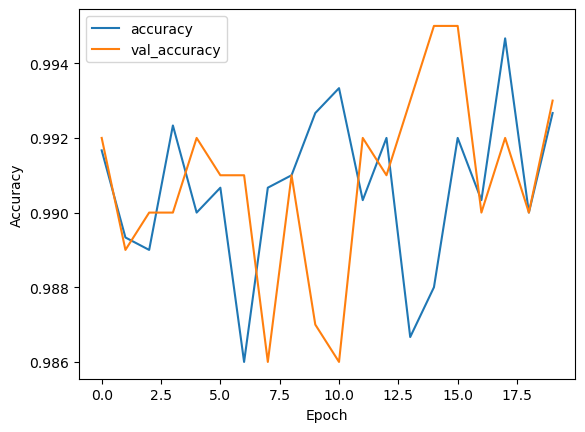

In [17]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()